# Coffe Shop Purchase Analytics

Artificial model consists on analysis of approximatelly 1,000 transactions in coffe shop.

All data is faked. So the main purpose is to detect some strong correlations, visualize them and construct statistics-driven predictions.

Breaking in pieces, we're interested in such visualization params:

1) Aggregate frequency of each kind of drink/meal in all transactions
2) Classify most common meal+drink combinations

Prediction model is dedicatated to:

1) Determine the most popular meal+drink combination based on customers transactions

With aim of high accuracy, with obvious, fast and robust implementation Tensorflow+Keras framework are used in research.
However, even in fact that simple Bayesian probability may be used in that research, our goal is in introspecting neural network way of combination determination. It's assambled to concancantenate current model with other factor based models consuming much more params determing the transaction, so complexity regards in the future


In [2]:
import os.path

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

For dataset it will be used kaggle opensourced csv file of hypotetical coffe shop. This code imports it via kagglehub open library and saves to cache directory

In [7]:
import kagglehub

path = kagglehub.dataset_download("sryasuka/coffee-shop-dataset")
filename = "coffee_shop_transactions.csv"

fullpath = os.path.join(path, filename)

print(fullpath)

/Users/shaya/.cache/kagglehub/datasets/sryasuka/coffee-shop-dataset/versions/1/coffee_shop_transactions.csv


Pandas library will be used to easily operate collected data values. Let's upload our csv file at first

In [8]:
import pandas as pd

df = pd.read_csv(fullpath)

print(df)

     TransactionID  Latte  Hazelnut Latte  Vanilla Latte  Creamy Aren Latte  \
0                1      0               0              1                  0   
1                2      0               0              0                  1   
2                3      0               0              0                  0   
3                4      1               0              0                  0   
4                5      0               0              1                  0   
..             ...    ...             ...            ...                ...   
995            996      0               0              1                  0   
996            997      0               0              0                  0   
997            998      0               0              1                  0   
998            999      0               0              0                  0   
999           1000      0               0              0                  0   

     Caramel Latte  Matcha Latte  Cappuccino  Caram

In current table transactionID is a primary key for a full purchase, so due to horizontal spreading of order details:
1) General amount of sold products may be calculated by vertically summarizing partitioned by each column, except for transactionID



In [9]:
column_sums = df.drop(columns=["TransactionID"]).sum()

print(column_sums)

Latte                     138
Hazelnut Latte            173
Vanilla Latte             149
Creamy Aren Latte         164
Caramel Latte             158
Matcha Latte              169
Cappuccino                167
Caramel Macchiato         173
Americano                 169
Matcha Bun                163
Cheese Toast              173
Chocolate Toast           172
Butter Toast              157
Cookies                   157
Croissant                 176
Egg Salad Toast           169
Fries                     175
Crispy Chicken Nuggets    161
dtype: int64


In matplotlib visualisation it looks like that:

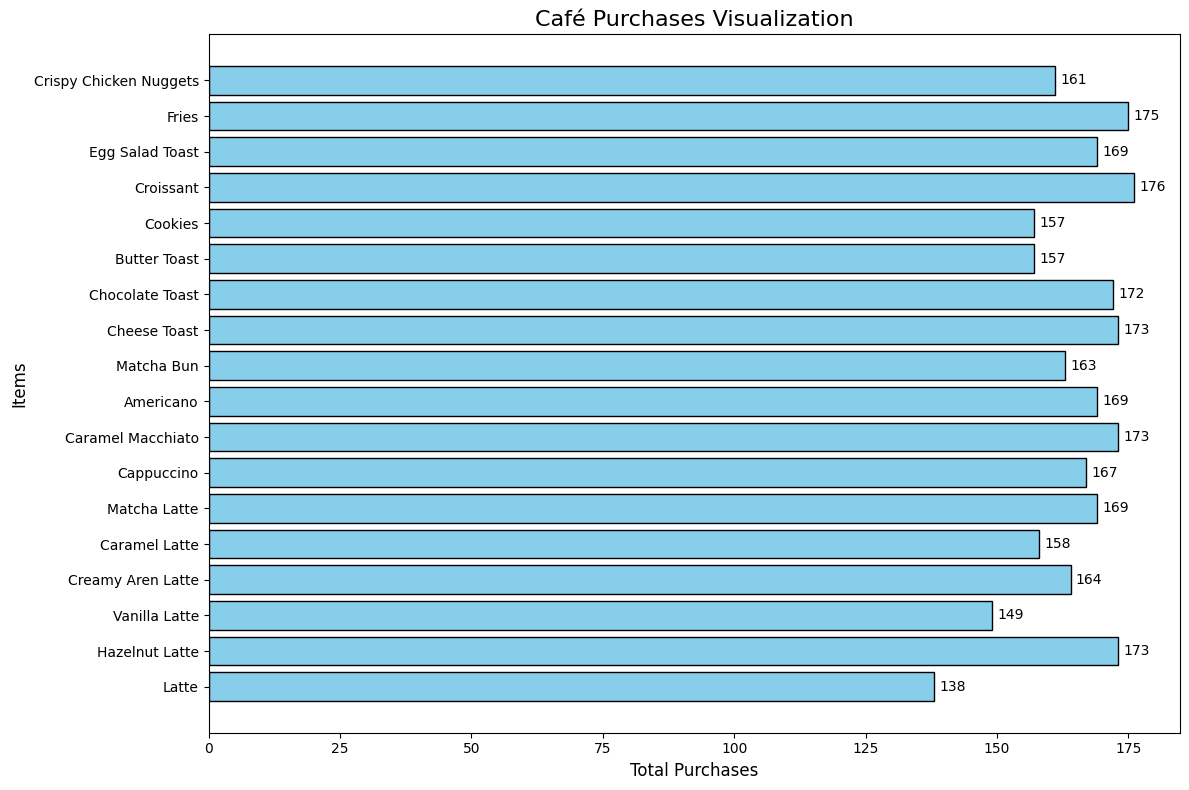

In [12]:
import matplotlib.pyplot as plt

items = list(column_sums.index)
values = column_sums.tolist()
# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(items, values, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Total Purchases", fontsize=12)
plt.ylabel("Items", fontsize=12)
plt.title("Café Purchases Visualization", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value annotations on bars
for index, value in enumerate(values):
    plt.text(value + 1, index, str(value), fontsize=10, va='center')

plt.tight_layout()
plt.show()
